In [160]:
# Imports
import pandas as pd
import numpy as np
from pathlib import Path
import pandas_datareader as pdr
import hvplot.pandas
import matplotlib.pyplot as plt
# import pyEX as p
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from pandas.tseries.offsets import DateOffset
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn import svm



In [161]:
# Select start and end dates
start_date = pd.Timestamp('2017-10-01', tz='America/New_York').isoformat()
end_date = pd.Timestamp('2021-10-01', tz='America/New_York').isoformat()



In [162]:
# Import the Yahoo Finance dataset into a Pandas Dataframe, in this case JP Morgan.
# We only need the date and the adjusted closing price. 
jpm_df = pdr.DataReader('JPM','yahoo',start_date,end_date)['Adj Close']


jpm_df.head()

Date
2017-10-02    85.915321
2017-10-03    86.367775
2017-10-04    85.489479
2017-10-05    86.640617
2017-10-06    86.488914
Name: Adj Close, dtype: float64

In [163]:
# Make the MACD and the signal line
exp1 = jpm_df.ewm(span=12, adjust=False).mean()
exp2 = jpm_df.ewm(span=26, adjust=False).mean()
macd = exp1 - exp2

exp3 = macd.ewm(span=9, adjust=False).mean()

In [164]:
#Change column names 
macd.head()
macd.rename("MACD")

Date
2017-10-02    0.000000
2017-10-03    0.036093
2017-10-04   -0.006104
2017-10-05    0.052735
2017-10-06    0.086130
                ...   
2021-09-27    0.980370
2021-09-28    1.419394
2021-09-29    1.736874
2021-09-30    1.786614
2021-10-01    2.077996
Name: MACD, Length: 1008, dtype: float64

In [165]:
exp3.rename("Signal")

Date
2017-10-02    0.000000
2017-10-03    0.007219
2017-10-04    0.004554
2017-10-05    0.014190
2017-10-06    0.028578
                ...   
2021-09-27    0.314303
2021-09-28    0.535321
2021-09-29    0.775632
2021-09-30    0.977828
2021-10-01    1.197862
Name: Signal, Length: 1008, dtype: float64

<AxesSubplot:label='6ff48265-38d2-4afc-bedc-c89b956a21b2'>

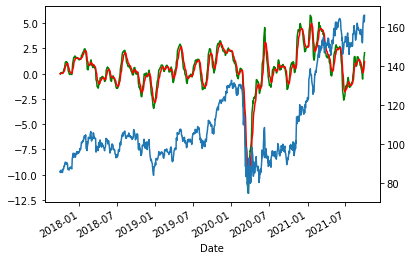

In [166]:
# Plot

macd.plot(label='JPM MACD', color='g')
ax = exp3.plot(label='Signal Line', color='r')
jpm_df.plot(ax=ax, secondary_y=True, label='')

In [167]:
# hvPlot 

macd.hvplot.line()
exp3.hvplot.line()

:Curve   [Date]   (Adj Close)

In [168]:
jpm = pd.concat([jpm_df,macd,exp3], axis=1)

jpm.columns = ['Adj Close', 'MACD', 'Signal Line']

jpm.head()

,Adj Close,MACD,Signal Line
Date,,,
2017-10-02,85.915321,0.000000,0.000000
2017-10-03,86.367775,0.036093,0.007219
2017-10-04,85.489479,-0.006104,0.004554
2017-10-05,86.640617,0.052735,0.014190
2017-10-06,86.488914,0.086130,0.028578


In [169]:
jpm.hvplot.line()

:NdOverlay   [Variable]
   :Curve   [Date]   (value)

In [170]:
def rsi(df, periods = 14, ema = True):
    """
    Returns a pd.Series with the relative strength index.
    """
    close_delta = jpm['Adj Close'].diff()

    # Make two series: one for lower closes and one for higher closes
    up = close_delta.clip(lower=0)
    down = -1 * close_delta.clip(upper=0)
    
    if ema == True:
	    # Use exponential moving average
        ma_up = up.ewm(com = periods - 1, adjust=True, min_periods = periods).mean()
        ma_down = down.ewm(com = periods - 1, adjust=True, min_periods = periods).mean()
    else:
        # Use simple moving average
        ma_up = up.rolling(window = periods, adjust=False).mean()
        ma_down = down.rolling(window = periods, adjust=False).mean()
        
    rsi = ma_up / ma_down
    rsi = 100 - (100/(1 + rsi))
    
    
    return rsi


In [171]:
jpm_rsi_signals = pd.DataFrame(jpm_rsi_df)
# jpm_rsi_signals['RSI'] = jpm_rsi_signals['Adj Close'].dropna()
jpm_rsi_signals.rename(columns={'Adj Close': 'RSI'}, inplace=True)




# jpm_rsi_signals.drop(columns=['Adj Close'])
# jpm_rsi_signals.drop(jpm_rsi_signals.tail(1).index, inplace=True)


In [172]:
jpm_rsi_signals.drop(jpm_rsi_signals.tail(1).index, inplace=True)

In [173]:
jpm_rsi_signals

,RSI
Date,
2017-10-02,NaN
2017-10-03,NaN
2017-10-04,NaN
2017-10-05,NaN
2017-10-06,NaN
...,...
2021-09-27,66.665290
2021-09-28,64.364059
2021-09-29,64.020277


In [174]:
# Add RSI signal type to dataframe
jpm_rsi_signals['RSI Signal'] = np.nan
jpm_rsi_signals

,RSI,RSI Signal
Date,,
2017-10-02,NaN,NaN
2017-10-03,NaN,NaN
2017-10-04,NaN,NaN
2017-10-05,NaN,NaN
2017-10-06,NaN,NaN
...,...,...
2021-09-27,66.665290,NaN
2021-09-28,64.364059,NaN
2021-09-29,64.020277,NaN


In [175]:
#  below 30 is oversold, while an RSI of over 70 suggests the shares are overbought. middle = hold 
for index, row in jpm_rsi_signals.iterrows():
    if row['RSI'] < 30:
        jpm_rsi_signals.at[index,'RSI Signal'] = 1
    elif row['RSI'] > 70:
        jpm_rsi_signals.at[index,'RSI Signal'] = -1
    else:
        jpm_rsi_signals.at[index,'RSI Signal'] = 0

In [176]:
jpm_rsi_signals.value_counts(['RSI Signal'])

RSI Signal
 0.0          885
-1.0          102
 1.0           21
dtype: int64

In [177]:
# Split the data into training and testing datasets.
rsi_X = jpm_rsi_signals[['RSI']].shift().dropna()

# Review the DataFrame
rsi_X.head()

,RSI
Date,
2017-10-23 00:00:00,72.065935
2017-10-24 00:00:00,69.997534
2017-10-25 00:00:00,76.693059
2017-10-26 00:00:00,77.042281
2017-10-27 00:00:00,79.431785


In [178]:
# Create the target set selecting the Signal column and assiging it to y
rsi_y = jpm_rsi_signals['RSI Signal']

# Review the value counts
rsi_y.value_counts()

 0.0    885
-1.0    102
 1.0     21
Name: RSI Signal, dtype: int64

In [179]:
# Select the start of the training period
rsi_training_begin = rsi_X.index.min()

# Display the training begin date
print(rsi_training_begin)

2017-10-23 00:00:00


In [180]:
# Select the ending period for the training data with an offset of 3 months
rsi_training_end = rsi_X.index.min() + DateOffset(months=12)

# Display the training end date
print(rsi_training_end)

2018-10-23 00:00:00


In [181]:
# Generate the X_train and y_train DataFrames
rsi_X_train = rsi_X.loc[rsi_training_begin:rsi_training_end]
rsi_y_train = rsi_y.loc[rsi_training_begin:rsi_training_end]

# Review the X_train DataFrame
rsi_X_train.head()

,RSI
Date,
2017-10-23 00:00:00,72.065935
2017-10-24 00:00:00,69.997534
2017-10-25 00:00:00,76.693059
2017-10-26 00:00:00,77.042281
2017-10-27 00:00:00,79.431785


In [182]:
# Generate the X_test and y_test DataFrames
rsi_X_test = rsi_X.loc[rsi_training_end+DateOffset(hours=1):]
rsi_y_test = rsi_y.loc[rsi_training_end+DateOffset(hours=1):]

# Review the X_test DataFrame
rsi_X_train.head()

,RSI
Date,
2017-10-23 00:00:00,72.065935
2017-10-24 00:00:00,69.997534
2017-10-25 00:00:00,76.693059
2017-10-26 00:00:00,77.042281
2017-10-27 00:00:00,79.431785


In [183]:
# Scale the features DataFrames

# Create a StandardScaler instance
scaler = StandardScaler()

# Apply the scaler model to fit the X-train data
X_scaler = scaler.fit(rsi_X_train)

# Transform the X_train and X_test DataFrames using the X_scaler
rsi_X_train_scaled = X_scaler.transform(rsi_X_train)
rsi_X_test_scaled = X_scaler.transform(rsi_X_test)

In [184]:
# Create the classifier model
rsi_svm_model = svm.SVC()

# Fit the model to the data using X_train_scaled and y_train
rsi_svm_model = rsi_svm_model.fit(rsi_X_train_scaled, rsi_y_train)

# Use the trained model to predict the trading signals for the training data
rsi_training_signal_predictions = rsi_svm_model.predict(rsi_X_train_scaled)

# Display the sample predictions
rsi_training_signal_predictions[:10]

array([-1.,  0., -1., -1., -1., -1., -1.,  0.,  0., -1.])

In [185]:
# Evaluate the model using a classification report
rsi_training_report = classification_report(rsi_y_train, rsi_training_signal_predictions)
print(rsi_training_report)

              precision    recall  f1-score   support

        -1.0       0.76      0.76      0.76        33
         0.0       0.95      0.96      0.96       217
         1.0       0.00      0.00      0.00         3

    accuracy                           0.92       253
   macro avg       0.57      0.57      0.57       253
weighted avg       0.91      0.92      0.92       253



/Users/alantemiryaev/opt/anaconda3/envs/dev/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/alantemiryaev/opt/anaconda3/envs/dev/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/alantemiryaev/opt/anaconda3/envs/dev/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [188]:
# Initiate the Logitstic model instance for RSI 
rsi_model = LogisticRegression()

In [189]:
# Fit the model using the training data
rsi_model.fit(rsi_X_train_scaled, rsi_y_train)

# Use the testing dataset to generate the predictions for the new model
rsi_pred = rsi_model.predict(rsi_X_test_scaled)

# Review the model's predicted values
rsi_pred

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
       -1.,  0.,  0., -1., -1., -1., -1., -1., -1., -1., -1., -1.,  0.,
       -1., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0

In [190]:
# Use a classification report to evaluate the model using the predictions and testing data
lr_rsi_training_report = classification_report(rsi_y_test, rsi_pred)

# Print the classification report
print(lr_rsi_training_report)

              precision    recall  f1-score   support

        -1.0       0.78      0.72      0.75        68
         0.0       0.95      0.98      0.96       654
         1.0       0.00      0.00      0.00        18

    accuracy                           0.93       740
   macro avg       0.57      0.57      0.57       740
weighted avg       0.91      0.93      0.92       740



/Users/alantemiryaev/opt/anaconda3/envs/dev/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/alantemiryaev/opt/anaconda3/envs/dev/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/alantemiryaev/opt/anaconda3/envs/dev/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [194]:
# Create a new empty predictions DataFrame.

# Create a predictions DataFrame
lr_rsi_predictions_df = pd.DataFrame(index=rsi_X_test.index)

# Add the SVM model predictions to the DataFrame
lr_rsi_predictions_df['Predicted'] = rsi_pred

# Add the actual returns to the DataFrame
lr_rsi_predictions_df['Actual Returns'] = jpm_rsi_signals['RSI Signal']

# Add the strategy returns to the DataFrame
lr_rsi_predictions_df['Strategy Returns'] = lr_rsi_predictions_df['Actual Returns'] * lr_rsi_predictions_df['Predicted']

# Review the DataFrame
lr_rsi_predictions_df.head(60)

,Predicted,Actual Returns,Strategy Returns
Date,,,
2018-10-24 00:00:00,0.0,1.0,0.0
2018-10-25 00:00:00,0.0,0.0,0.0
2018-10-26 00:00:00,0.0,0.0,0.0
2018-10-29 00:00:00,0.0,0.0,0.0
2018-10-30 00:00:00,0.0,0.0,0.0
2018-10-31 00:00:00,0.0,0.0,0.0
2018-11-01 00:00:00,0.0,0.0,0.0
2018-11-02 00:00:00,0.0,0.0,0.0
2018-11-05 00:00:00,0.0,0.0,0.0


<AxesSubplot:xlabel='Date'>

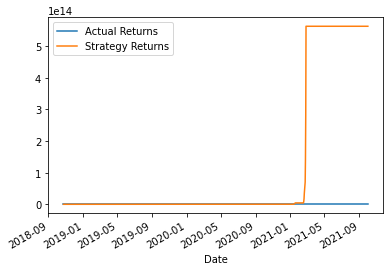

In [195]:
# Plot the actual returns versus the strategy returns
(1 + lr_rsi_predictions_df[['Actual Returns', 'Strategy Returns']]).cumprod().plot()

## Create the model


In [186]:
#Add a trade type column to the dataframe

jpm['trade type'] = np.nan
jpm['trade type'] = jpm['trade type'].astype(str)
jpm.head()

,Adj Close,MACD,Signal Line,trade type
Date,,,,
2017-10-02,85.915321,0.000000,0.000000,nan
2017-10-03,86.367775,0.036093,0.007219,nan
2017-10-04,85.489479,-0.006104,0.004554,nan
2017-10-05,86.640617,0.052735,0.014190,nan
2017-10-06,86.488914,0.086130,0.028578,nan


In [187]:

jpm.drop(['trade_type'], axis=1)

KeyError: "['trade_type'] not found in axis"

In [ ]:
#Trading strategy, buy when the MACD signal line moves from negative. Sell vice versa.

jpm['lag'] = np.nan
jpm.head()

jpm.drop(['trade_type'], axis=1)

In [ ]:
jpm['lag'] = jpm['Signal Line'].shift()

In [ ]:
jpm.head()

In [ ]:
for index, row in jpm.iterrows():
    if row['Signal Line'] > 0 and row['lag'] < 0:
        jpm.at[index,'trade type'] = 'Buy'
    elif row['Signal Line']<0 and row['lag']>0:
        jpm.at[index,'trade type'] = 'Sell'
    else:
        jpm.at[index,'trade type'] = 'Hold'

In [ ]:
jpm.head()

In [ ]:
jpm['trade type'].value_counts()

In [ ]:
#Alternative method for scaling and training ect.

X = jpm[['Adj Close', 'MACD','Signal Line', 'lag']].shift().dropna().copy()

jpm['signal'] = 0.0
jpm.loc[(jpm['trade type'] == 'Buy'), 'signal'] = 1
jpm.loc[(jpm['trade type'] == 'Sell'), 'signal'] = -1
jpm.loc[(jpm['trade type'] == 'Hold'), 'signal'] = 0

y = jpm['signal'].copy()

# Select the start of the training period
training_begin = X.index.min()

# Select the ending period for the training data with an offset of 3 months
training_end = X.index.min() + DateOffset(years=3)


In [ ]:
training_end

In [ ]:
# Generate the X_train and y_train DataFrames
X_train = X.loc[training_begin:training_end]
y_train = y.loc[training_begin:training_end]

# Display sample data
X_train.head()

In [ ]:
# Generate the X_test and y_test DataFrames
X_test = X.loc[training_end:]
y_test = y.loc[training_end:]

# Display sample data
X_test.head()

In [ ]:
# Create a StandardScaler instance
scaler = StandardScaler()

# Apply the scaler model to fit the X_train data
X_scaler = scaler.fit(X_train)

# Transform the X_train and X_test DataFrames using the X_scaler
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [ ]:
y_train.value_counts()

In [ ]:

# Create the classifier model
svm_model = svm.SVC()

# Fit the model to the data using X_train_scaled and y_train
svm_model = svm_model.fit(X_train_scaled, y_train)

# Use the trained model to predict the trading signals for the training data
training_signal_predictions = svm_model.predict(X_train_scaled)

# Display the sample predictions
training_signal_predictions[:10]

In [ ]:
# Evaluate the model using a classification report
training_report = classification_report(y_train, training_signal_predictions)
print(training_report)